# Floodnet : Evaluation part

In [227]:
#Choose whether you want to 
# use all images from test set (which requires to download the folder data from https://drive.google.com/drive/folders/1jOyH0aNXcN5F2uLGyGyAoWUbT8EWYZFd?usp=sharing)
# or only the images given in the repository
all_images = True   #True for first choice, False otherwise

## Imports

In [228]:
import sys
!pip install mlxtend tqdm albumentations torch
!pip install utils

In [229]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2

from torch import nn
import torch.nn.functional as F

from torch.optim import SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, jaccard_score
from mlxtend.plotting import plot_confusion_matrix

import time

from torch.optim.lr_scheduler import StepLR

import utils as functions

In [230]:
#choose the device cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Dataset

In [231]:
class FloodData(Dataset):

    #map between label class names and indices
    LABEL_CLASSES = {
      'background': 		  0,
      'building-flooded': 			    1,
      'building-non-flooded': 	  2,
      'road-flooded': 				      3,
      'road-non-flooded': 			    4,
      'water': 			    5,
      'tree':   6,
      'vehicle': 				    7,
      'pool': 				    8,
      'grass': 			  9
    }
    
    #initialize the dataset
    def __init__(self, transforms=None, split='train'):
        
        self.transforms = transforms
        
        #create data
        if all_images : 
        
            #load image/mask names and store them in SPLIT
            SPLIT = pd.read_csv("FloodNet_split_train_valid_test.csv", sep=',', header=None, names=["Column1", "Column2", "Column3"])
            SPLIT["Column1"] = SPLIT["Column1"].map(lambda x: "data/image/" + x)
            SPLIT["Column2"] = SPLIT["Column2"].map(lambda x: "data/mask/" + x)

            #take the set corresponding to the given split (train, validation or test)
            splitted_set = SPLIT[SPLIT["Column3"]==split]
            
            #prepare data (list of tuples of (image path, label class))
            self.data = list(zip(splitted_set["Column1"], splitted_set["Column2"]))
        
        else : 
            
            #image number for test data
            test_set = [6707, 6829, 6838, 6960, 7331, 7523, 7571, 7594, 10828, 10840, 6359, 6465, 6512, 6549, 6614, 6747, 6792, 6808, 6953]
            test_set_images = []
            test_set_labels = []
            for nb in range(len(test_set)):
                test_set_images.append("data/test_image/" + str(test_set[nb]) + ".jpg")
                test_set_labels.append("data/test_mask/" + str(test_set[nb]) + "_lab.png")
            
            #prepare data (list of tuples of (image path, label class))
            self.data = list(zip(test_set_images, test_set_labels))
        
    #give the length of the dataset
    def __len__(self):
        return len(self.data)

    #give the transformed image and mask
    def __getitem__(self, x):
        #get the image and mask names
        imgName, labelsName = self.data[x]

        #load pixel values and apply transforms
        img = np.array(Image.open(imgName))
        labels = np.array(Image.open(labelsName))
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=labels)
            img = transformed['image']
            labels = transformed['mask']
        else:
            img, labels = img[:3000, :4000,:], labels[:3000, :4000]
        img, labels = torch.tensor(img).float(), torch.tensor(labels).long()
        
        #move band dimension to the first dimension, because it is expected like this in the model
        img = torch.movedim(img, 2, 0)

        return img, labels

In [232]:
#already computed mean and standard deviation
mean, std = [106.5385, 116.1601,  87.6059], [53.1837, 49.5205, 53.5828]

#definitions of the transforms
transform_val = A.Compose([
    A.RandomSizedCrop(min_max_height = [1000, 2500], height=713, width=713),
    #A.CenterCrop(height=713, width=713),
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

In [233]:
#create test sets
test_dataset = FloodData(transforms = transform_val, split = 'test')
test_dl = DataLoader(test_dataset, batch_size = 1, shuffle = False)

## Models

### Resnet model

In [234]:
#class used for PSPNet
#source : https://github.com/hszhao/semseg/tree/master/model
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [212]:
#function and class used for PSPNet
#source : https://github.com/hszhao/semseg/tree/master/model
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            
        #on a décalé
        self.conv2 = conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = conv3x3(64, 64) #128)
        self.bn3 = nn.BatchNorm2d(64) #128)
            
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    # for the PSPNet, this forward is never used. We will still leave it for completion
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### PPM model

In [213]:
#class used for PSPNet
#source : https://github.com/hszhao/semseg/tree/master/model
class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        #print("PPM size of x:", x_size)
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

### PSPNet model

In [214]:
#main source : https://github.com/hszhao/semseg/tree/master/model
class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=10, zoom_factor=8, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        #set parameters
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.criterion = criterion    
        
        #load Resnet model from 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth'
        path_to_pretrained = "./resnet101.pth"
        resnet = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=1000, deep_base=False)
        resnet.load_state_dict(torch.load(path_to_pretrained), strict=False)

        #create first layers, taken from Resnet
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        #change parameters for layers 3 and 4
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
        #feature dimension after Resnet
        fea_dim = 2048
        
        #create the pyramid pooling module
        self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
        fea_dim *= 2
        
        #create the last layers
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )


    def forward(self, x, y=None):
        #set size parameters
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        #apply PSPNet layers
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        #if training mode, compute the loss
        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x

## Prediction functions

In [215]:
#skip the calculation of the gradient graph here to save time
@torch.no_grad() 

#compute predictions on the given batch
def prediction_step(batch, model, criterion, device="cuda"):
    #evaluation mode
    model.eval()
    
    #retrieve image and label from the batch
    x, y = batch
    
    #move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    #forward pass
    y_hat = model(x)
    
    #loss calculation (only for statistics)
    loss = criterion(y_hat, y)
    
    #compute the accuracy for statistics
    predictions = y_hat.argmax(1).cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()
    loss = loss.cpu().detach().numpy()
    accuracy = (predictions == ground_truth).mean()
    
    return loss, accuracy, predictions, ground_truth

In [216]:
#compute predictions and performances for the given dataloader
def validation(dataloader, model, criterion, breaking_point=10, returning="all", device="cuda"):
    #to store statisticss
    losses, accuracies, predictions, ground_truths = [], [], [], []
    

    #compute a prediction step for each batch
    for batch in dataloader:
        #call prediction_step
        loss, accuracy, prediction, ground_truth = prediction_step(batch, model, criterion, device)

        #append to stats
        losses.append(loss)
        accuracies.append(accuracy)
        predictions.append(prediction)
        ground_truths.append(ground_truth)

    #average val losses and accuracies over batches
    losses, accuracies = np.stack(losses).mean(), np.stack(accuracies).mean()
    
    #compute balanced accuracy and Intersection over Union (IoU)
    predictions, ground_truths = np.vstack(predictions), np.vstack(ground_truths)
    val_pred_new = np.concatenate(np.concatenate(predictions))
    val_ground_truth_new = np.concatenate(np.concatenate(ground_truths))
    bal_acc = balanced_accuracy_score(y_true=val_ground_truth_new, y_pred=val_pred_new)
    IoU = jaccard_score(y_true=val_ground_truth_new, y_pred=val_pred_new, average=None)

    #choose what you want to return
    if returning=="stats":
        return losses, accuracies, bal_acc, IoU
    elif returning=="predictions":
        return predictions, ground_truths
    else:
        return predictions, ground_truths, losses, accuracies, bal_acc, IoU

## Model initialization

In [217]:
#initialize criterion for the loss and import the trained model
class_weights=torch.tensor([0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]).float()
criterion=nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
criterion=criterion.to("cuda")
model = torch.load("model_param.pth")
model= nn.DataParallel(model)

## Prediction on the test set

In [218]:
#predict classes on test set and compute performances scores
test_predictions, test_ground_truths, test_losses, test_accuracies, test_bal_acc, test_IoU  = validation(test_dl, model, criterion, breaking_point=2, device=DEVICE)

## Statistics

In [219]:
#compute and displlay the confusion matrix
def print_confusion_matrix(prediction, ground_truth, save_name='train_confusion_matrix'):
    labels_in_data = []
    for key in FloodData.LABEL_CLASSES.keys():
        if FloodData.LABEL_CLASSES[key] in ground_truth:
            labels_in_data.append(key)

    cm = confusion_matrix(y_true=ground_truth, y_pred=prediction)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10,10), cmap="Blues", class_names=labels_in_data)
    plt.xlabel('Predicted label', fontsize=18)
    plt.ylabel('True label', fontsize=18)
    fig.savefig(save_name+'.pdf', format='pdf', bbox_inches = 'tight')

Accuracy : 76.98
Balanced accuracy : 54.79
Loss : 0.62
Intersection over union: [0.         0.22723486 0.40367205 0.24462429 0.59891146 0.7450936
 0.39866879 0.         0.41478703 0.7609426 ], mIoU: 0.4215482988866262


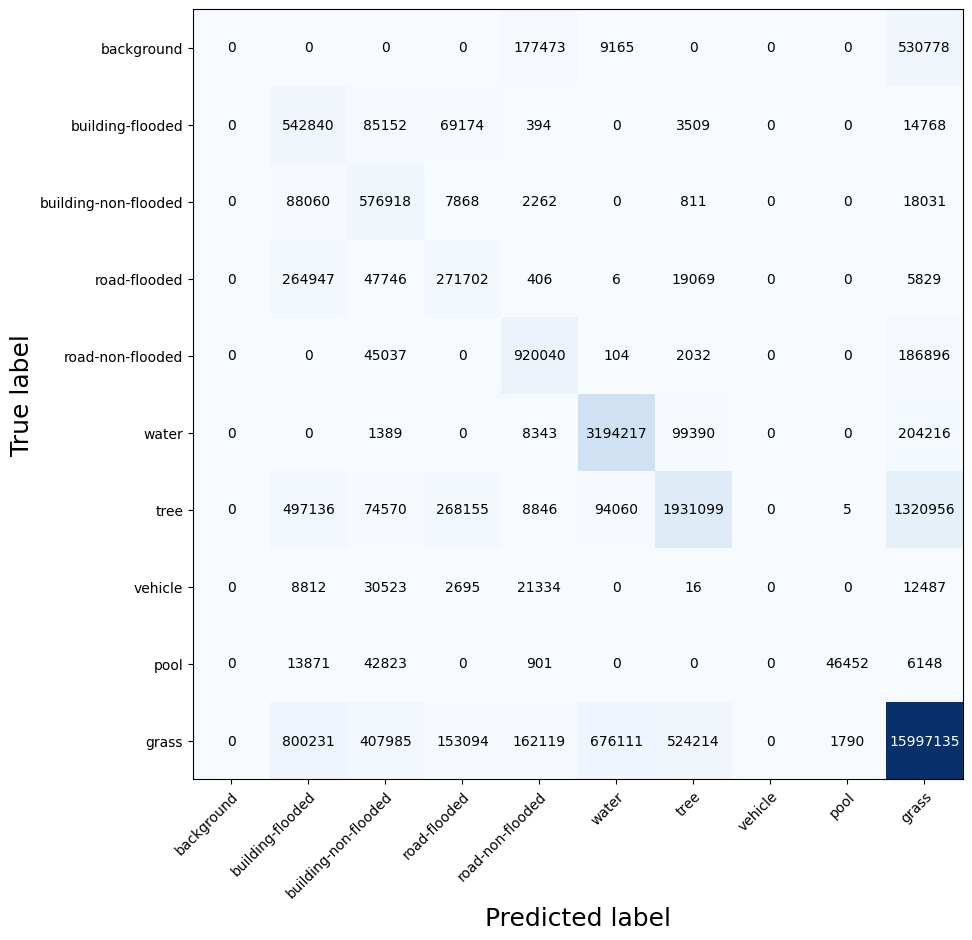

In [224]:
#show statistics
print(f"Accuracy : {test_accuracies*100:.2f}")
print(f"Balanced accuracy : {test_bal_acc*100:.2f}")
print(f"Loss : {test_losses:.2f}")
print(f"Intersection over union: {test_IoU}, mIoU: {test_IoU[1:].mean()}")

#confusion matrix for test set
test_pred_new = np.concatenate(np.concatenate(test_predictions))
test_ground_truth_new = np.concatenate(np.concatenate(test_ground_truths))
alist = []
for i in range(len(test_pred_new)):
    if test_pred_new[i] not in alist :
        alist.append(test_pred_new[i])
print_confusion_matrix(test_pred_new, test_ground_truth_new, save_name='test_confusion_matrix')

## Visualization of the predictions

In [225]:
#functions to displlay predictions
def get_label_image(label_map):
    colors = np.array([[0, 0, 0], # Background: black
                       [255, 51, 51],   # Building flooded: orange
                       [179, 81, 77],   # Building non-flooded: brown
                       [161, 161, 0],   # Road flooded: dark green
                       [153, 153, 153], # Road non-flooded
                       [0, 255, 255],   # Water: turquoise
                       [51, 51, 255],   # Tree: blue
                       [255, 102, 255], # Vehicle: pink
                       [255, 0, 0],     # Pool: red
                       [51, 255, 51]])  # Grass: green  
    colors = colors.astype(np.uint8)
    color_map = np.zeros((label_map.shape[0], label_map.shape[1], 3)).astype(np.uint8)
    for label_id in range(colors.shape[0]):
        color_map[label_map == label_id] = colors[label_id, :]
    return color_map


def display_all(ground_truth, predictions, image_nr):   
    f, ax = plt.subplots(1,2, figsize=(8, 8))
    
    ax[0].imshow(get_label_image(ground_truth[image_nr]))
    ax[0].set_title('True labels')
    
    ax[1].imshow(get_label_image(predictions[image_nr]))
    ax[1].set_title('Predicted labels')
    
    plt.show()
    save_name = "pred_test"
    f.savefig("Results/"+save_name+str(image_nr)+'.pdf', format='pdf', bbox_inches = 'tight')

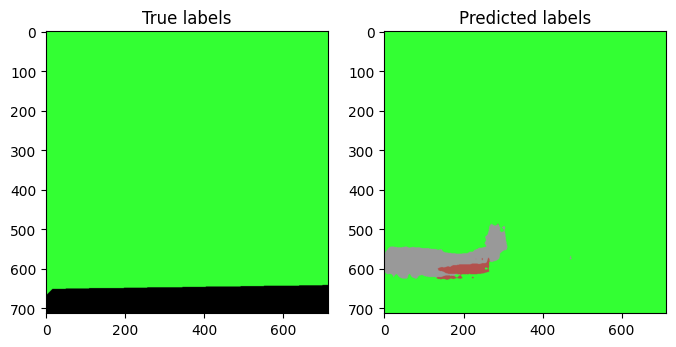

0 data/image/10828.jpg


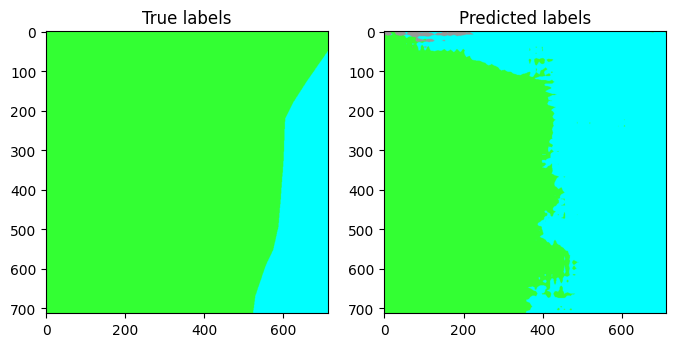

1 data/image/10840.jpg


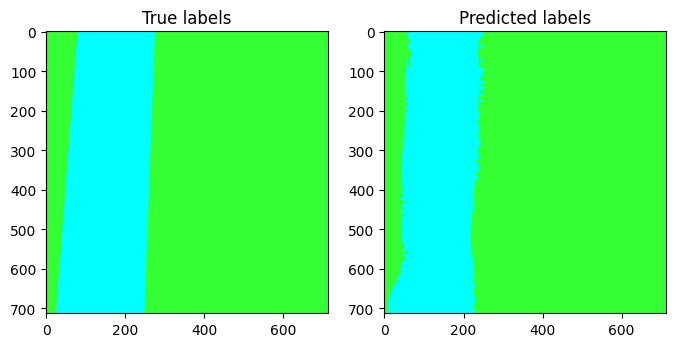

2 data/image/6359.jpg


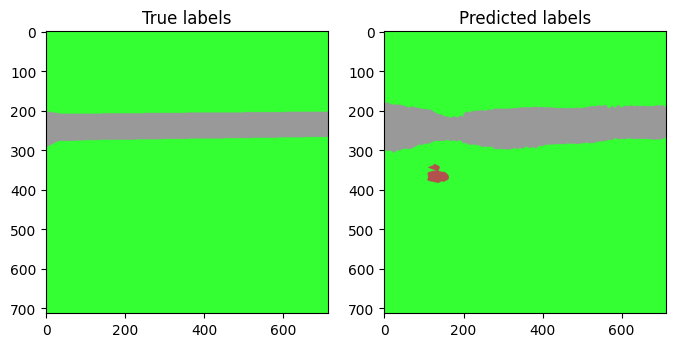

3 data/image/6395.jpg


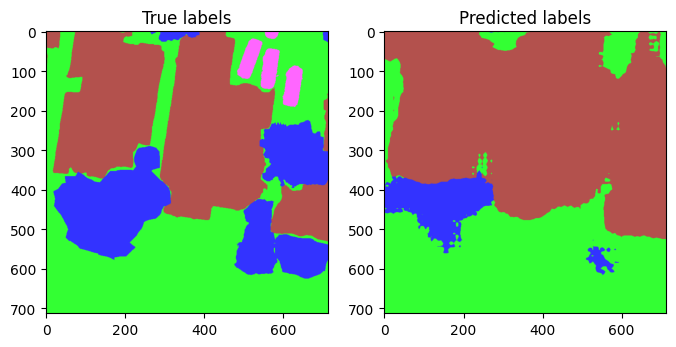

4 data/image/6465.jpg


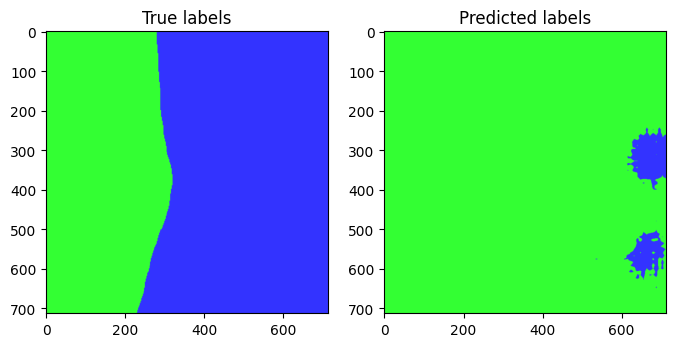

5 data/image/6512.jpg


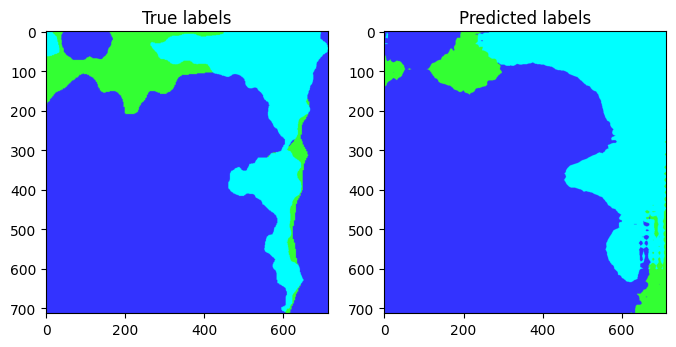

6 data/image/6549.jpg


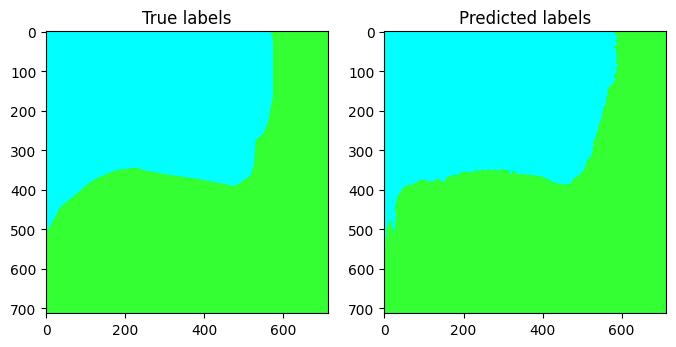

7 data/image/6614.jpg


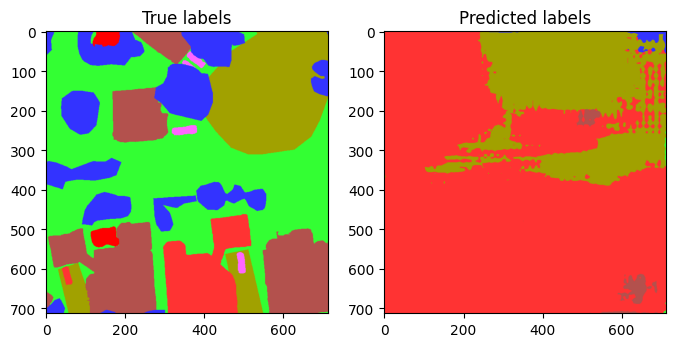

8 data/image/6707.jpg


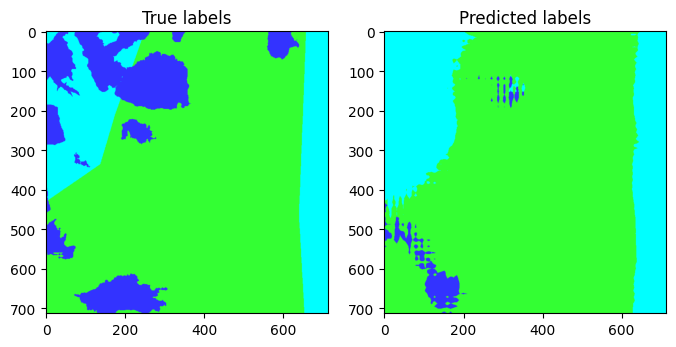

9 data/image/6747.jpg


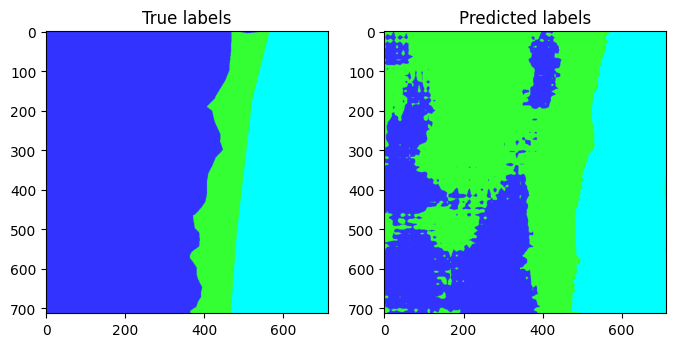

10 data/image/6792.jpg


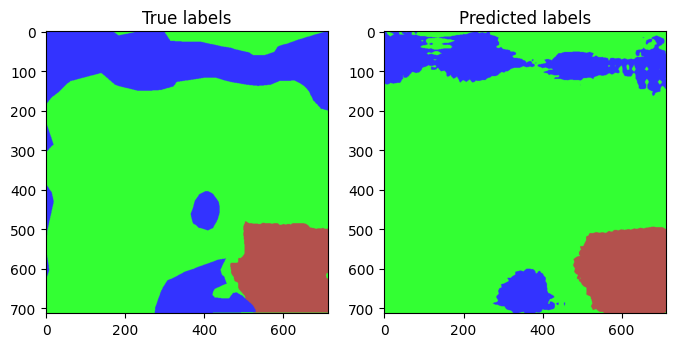

11 data/image/6808.jpg


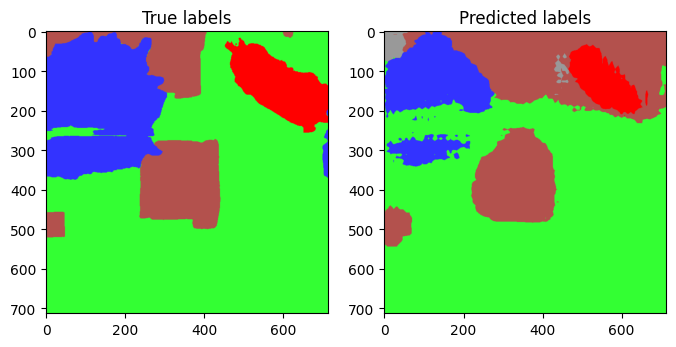

12 data/image/6829.jpg


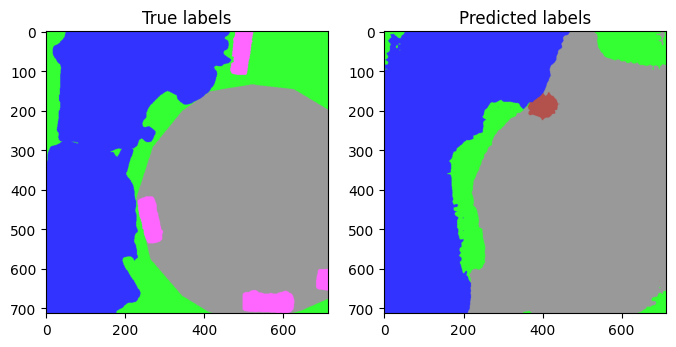

13 data/image/6838.jpg


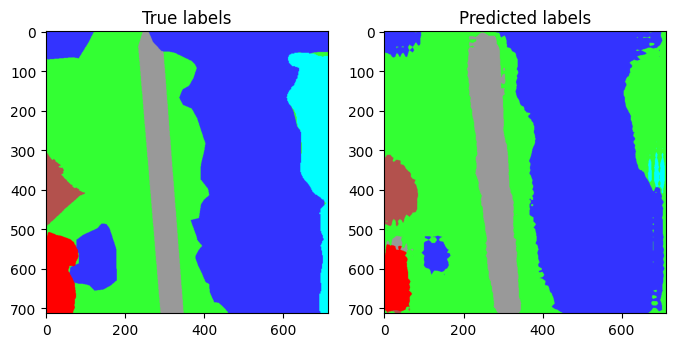

14 data/image/6953.jpg


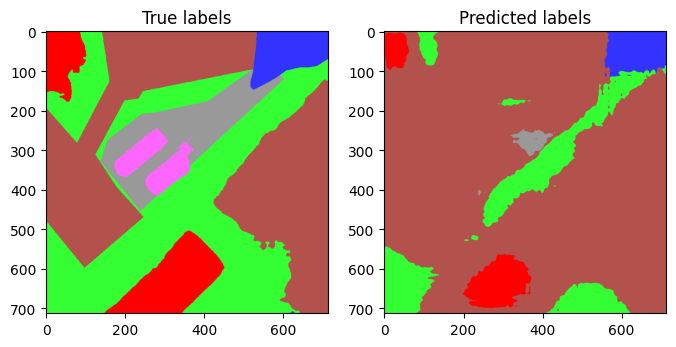

15 data/image/6960.jpg


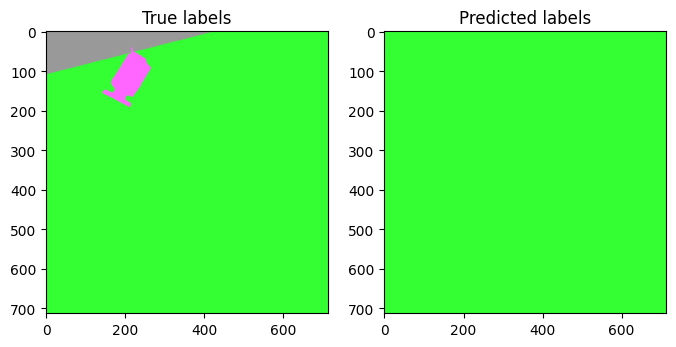

16 data/image/6994.jpg


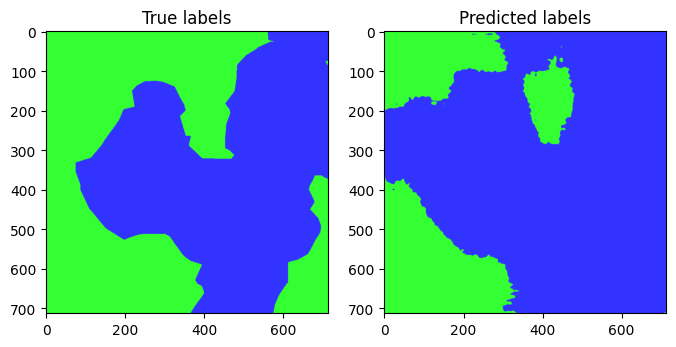

17 data/image/7010.jpg


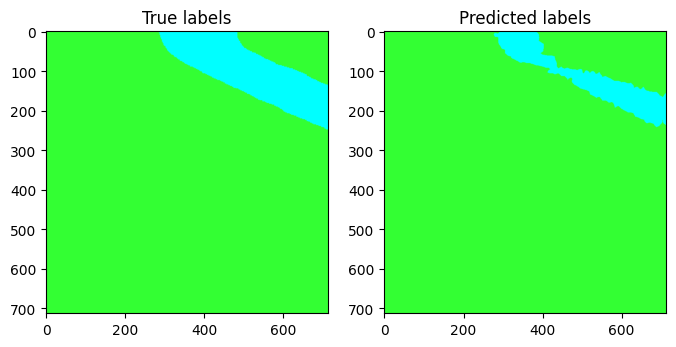

18 data/image/7049.jpg


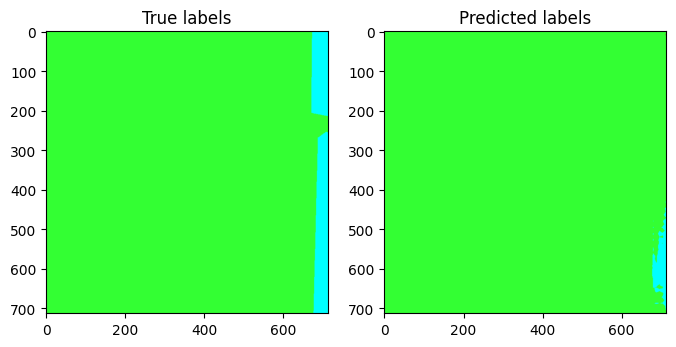

19 data/image/7081.jpg


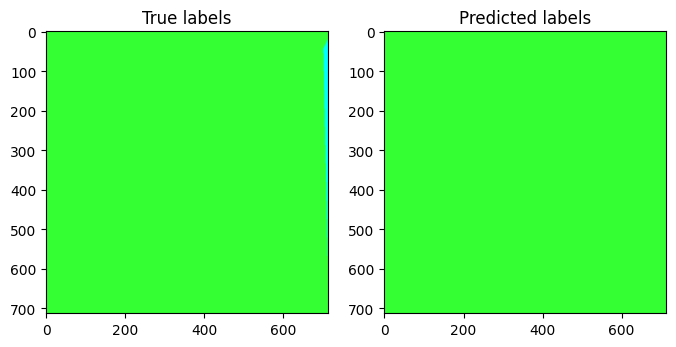

20 data/image/7083.jpg


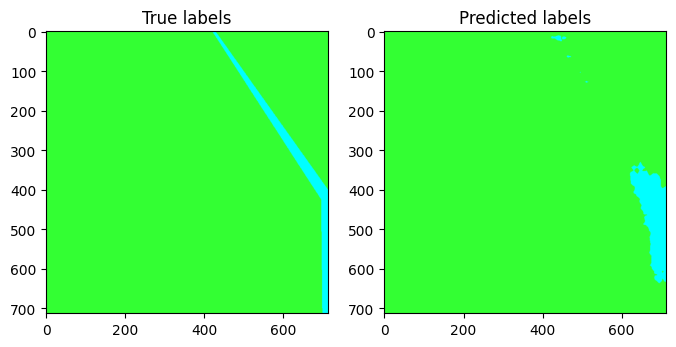

21 data/image/7102.jpg


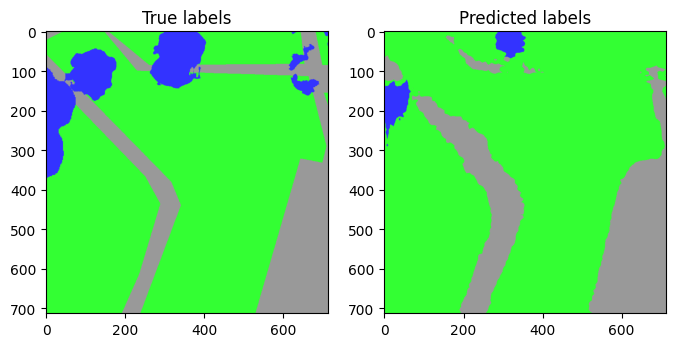

22 data/image/7128.jpg


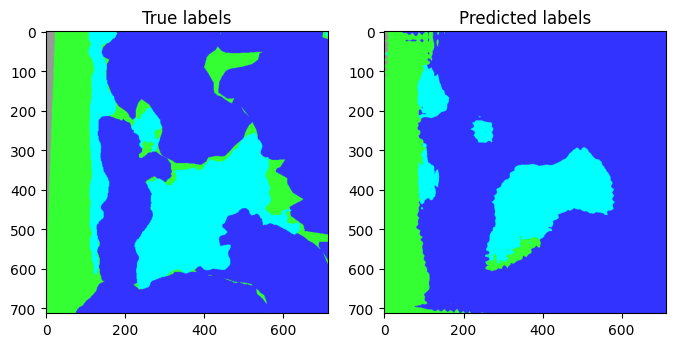

23 data/image/7199.jpg


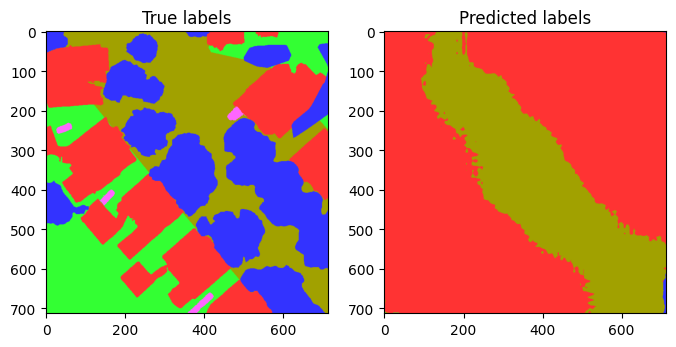

24 data/image/7331.jpg


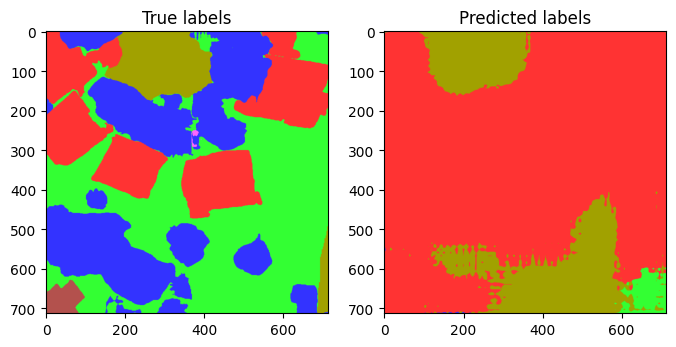

25 data/image/7463.jpg


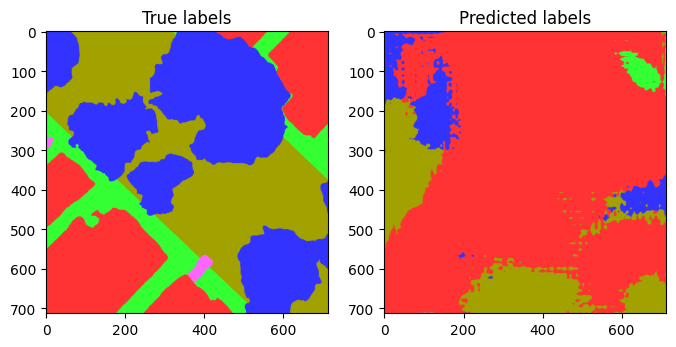

26 data/image/7523.jpg


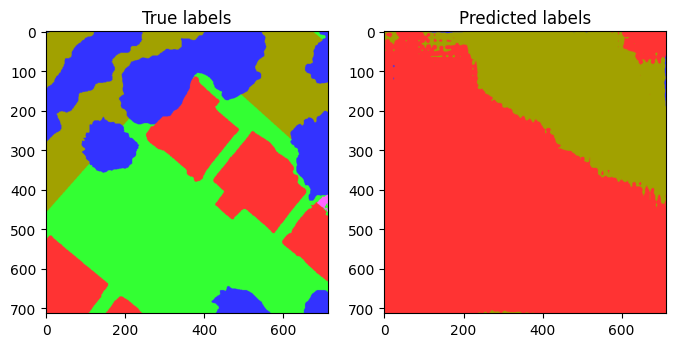

27 data/image/7571.jpg


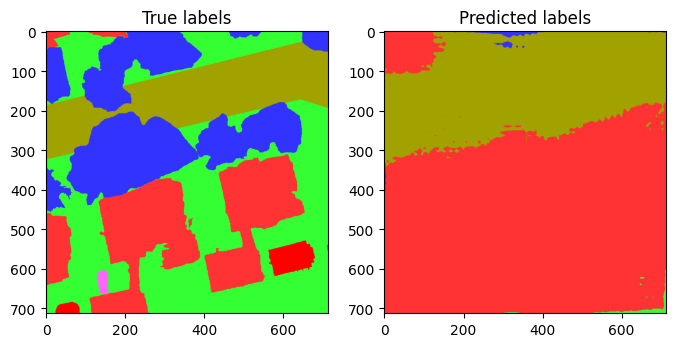

28 data/image/7587.jpg


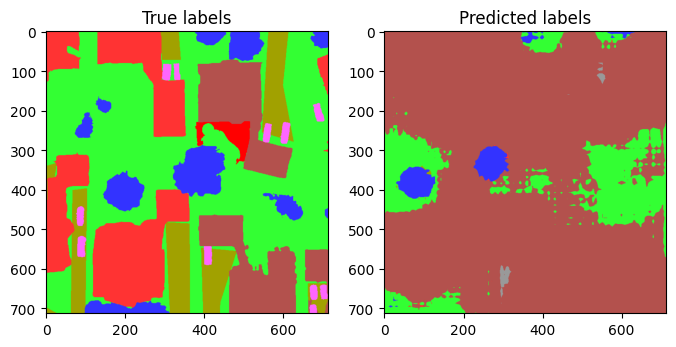

29 data/image/7594.jpg


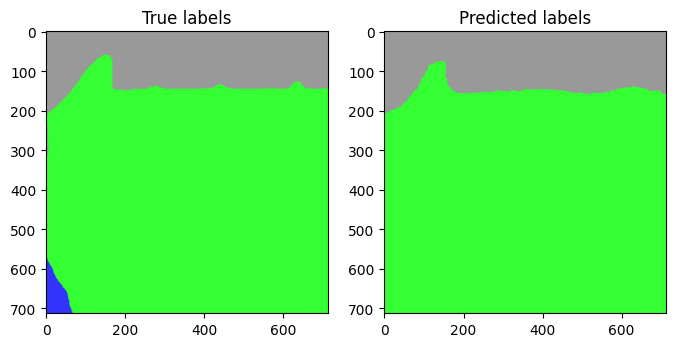

30 data/image/7674.jpg


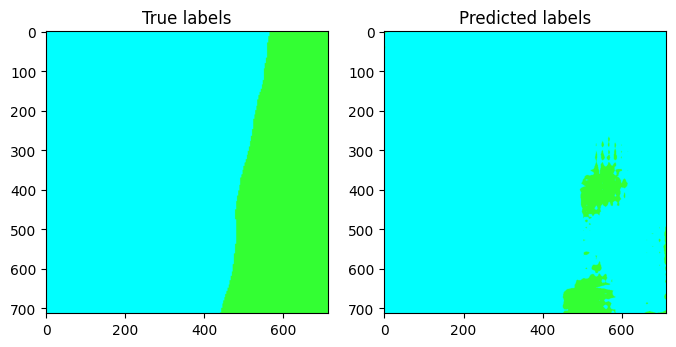

31 data/image/7706.jpg


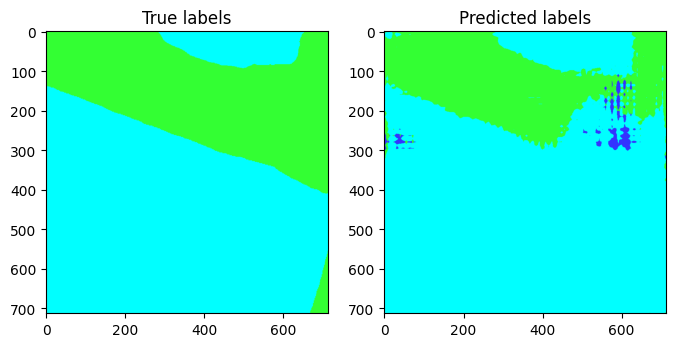

32 data/image/7711.jpg


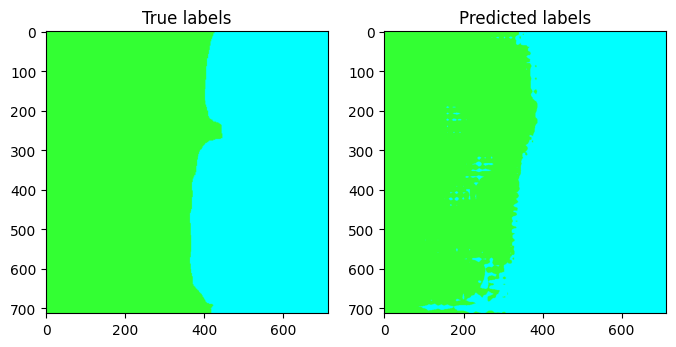

33 data/image/7713.jpg


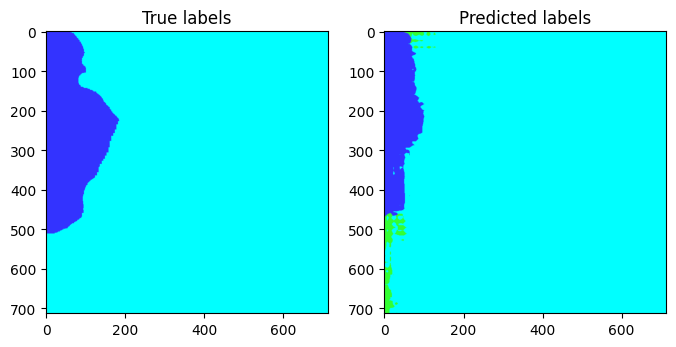

34 data/image/7749.jpg


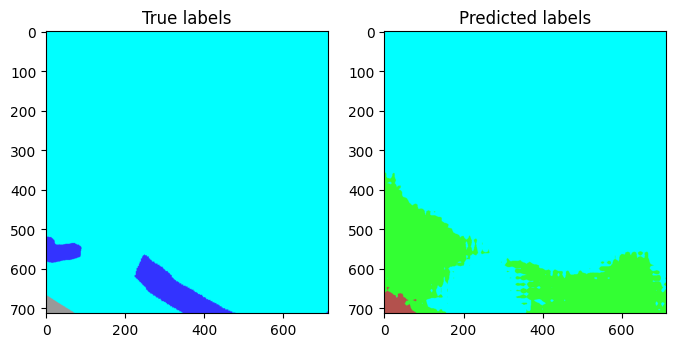

35 data/image/7752.jpg


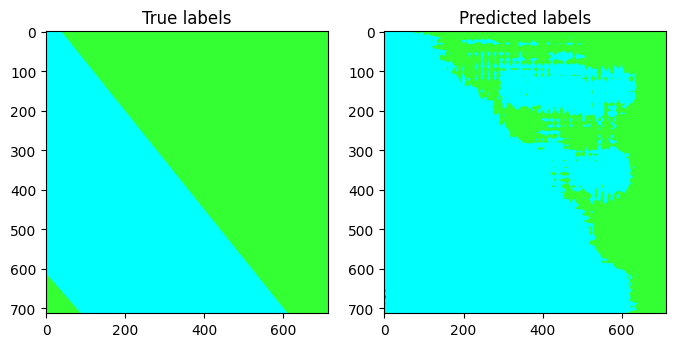

36 data/image/7791.jpg


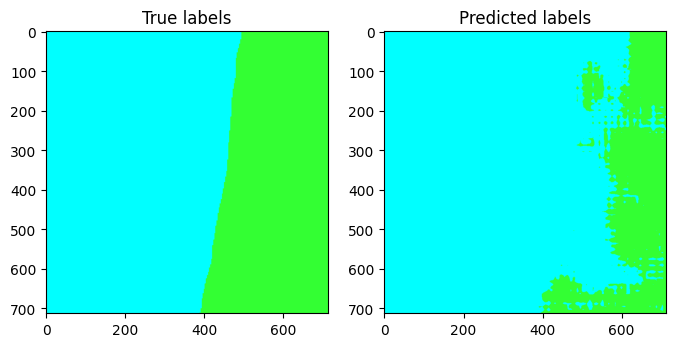

37 data/image/7802.jpg


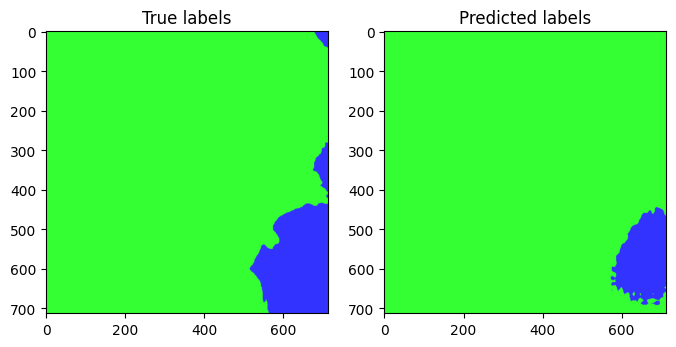

38 data/image/7831.jpg


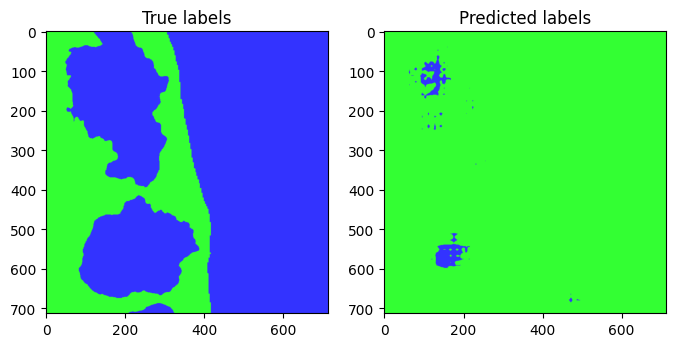

39 data/image/7879.jpg


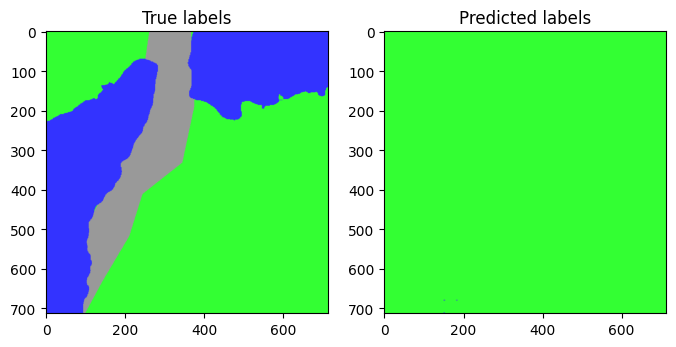

40 data/image/7884.jpg


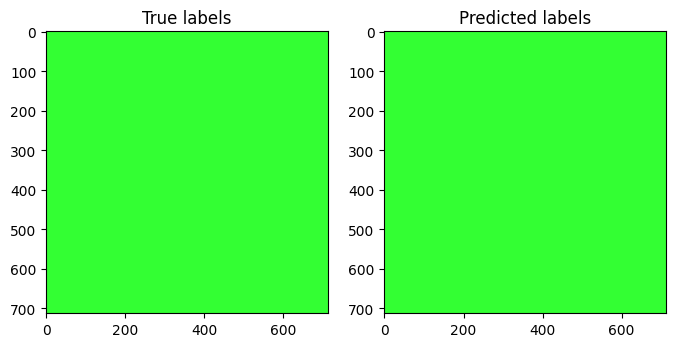

41 data/image/7907.jpg


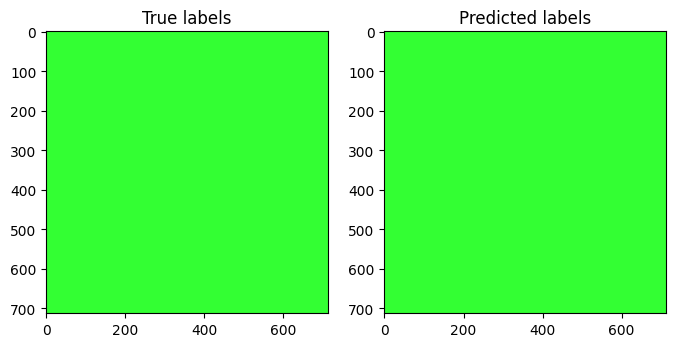

42 data/image/7918.jpg


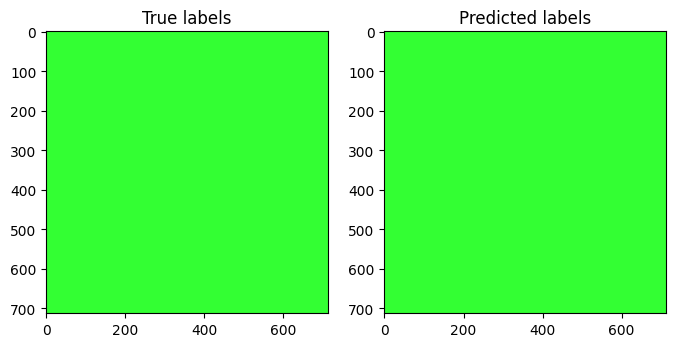

43 data/image/7925.jpg


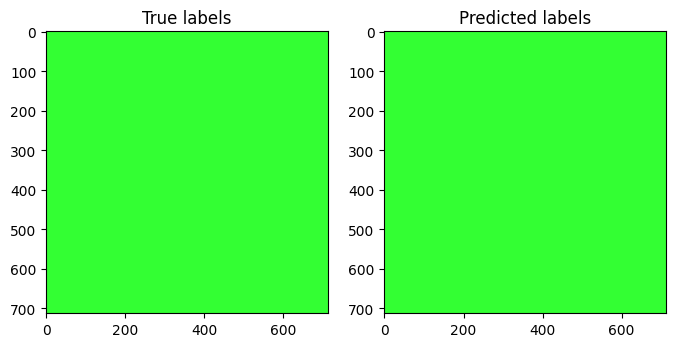

44 data/image/7973.jpg


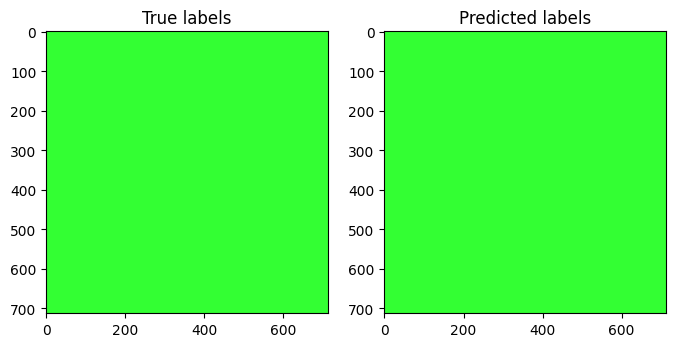

45 data/image/8015.jpg


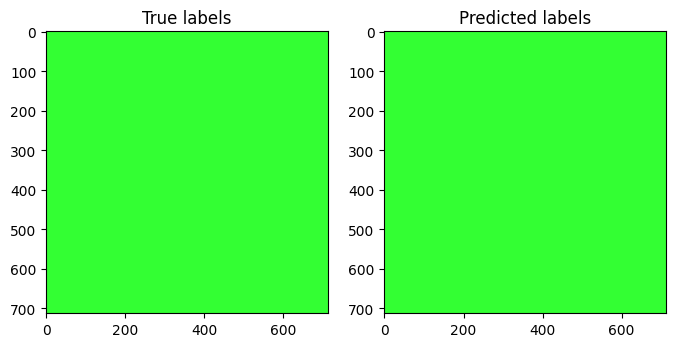

46 data/image/8157.jpg


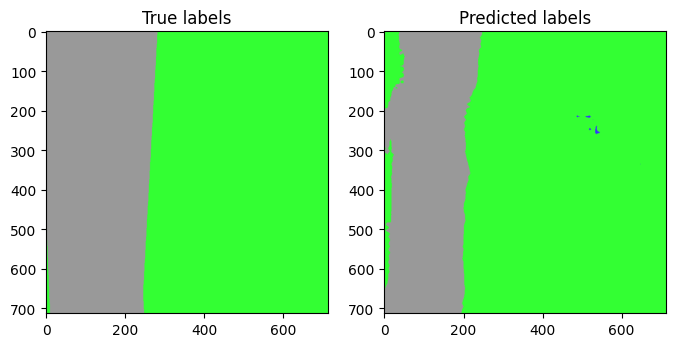

47 data/image/8172.jpg


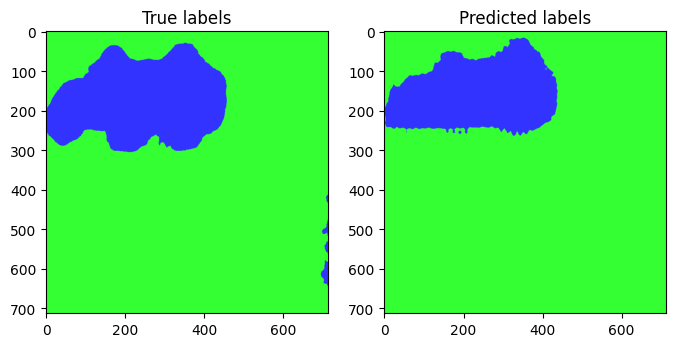

48 data/image/8244.jpg


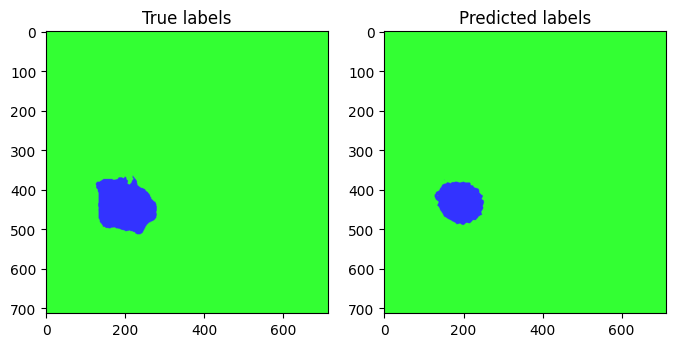

49 data/image/8334.jpg


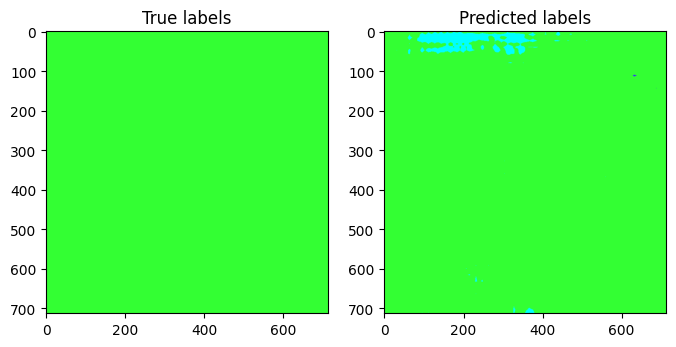

50 data/image/8379.jpg


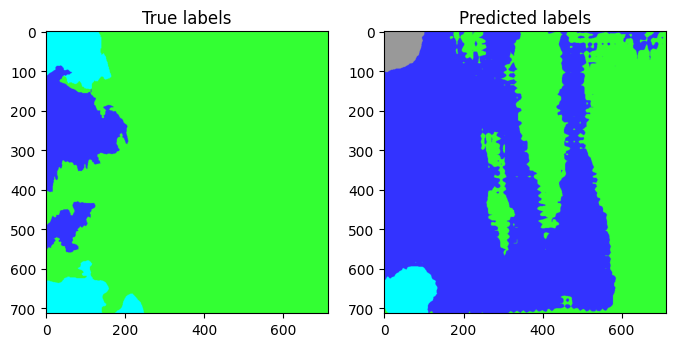

51 data/image/8394.jpg


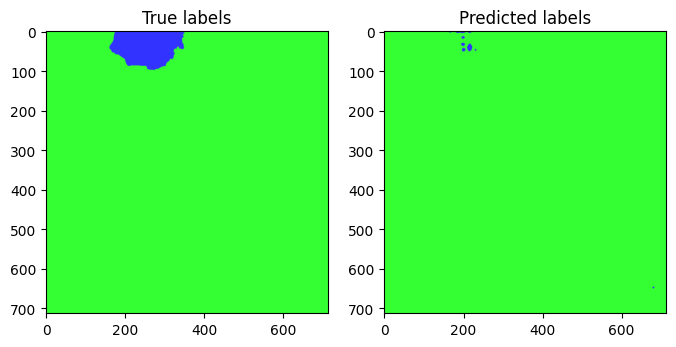

52 data/image/8429.jpg


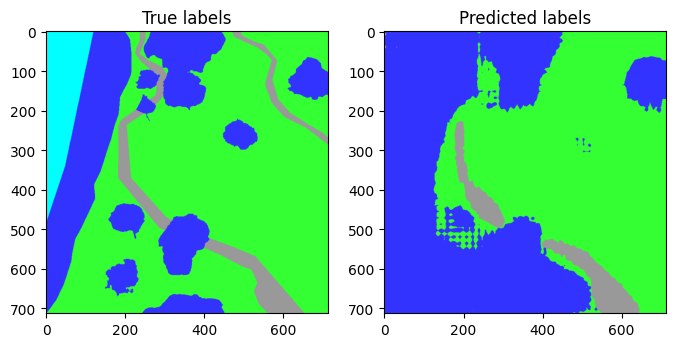

53 data/image/8488.jpg


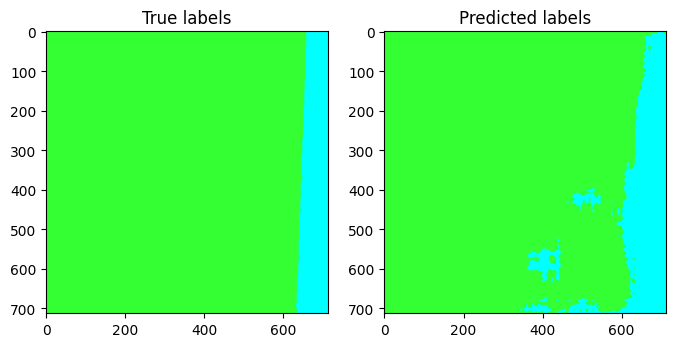

54 data/image/8597.jpg


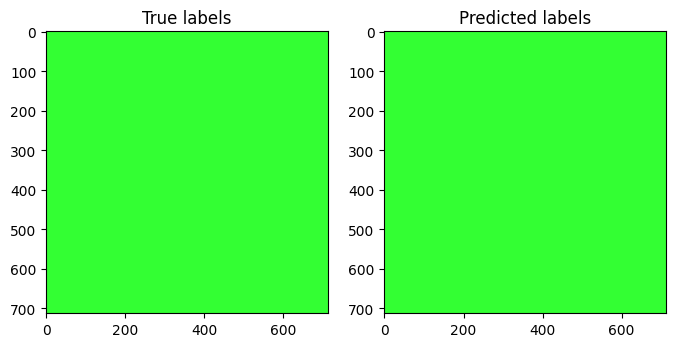

55 data/image/8859.jpg


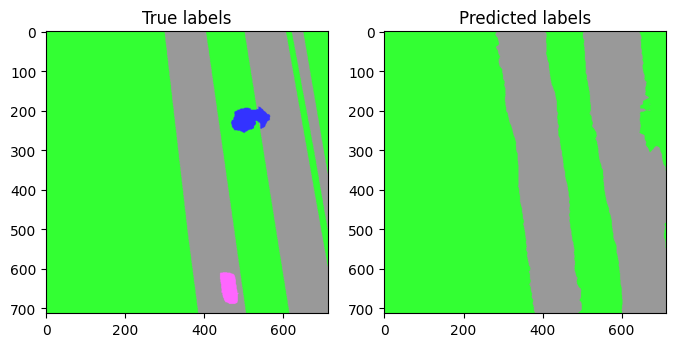

56 data/image/8928.jpg


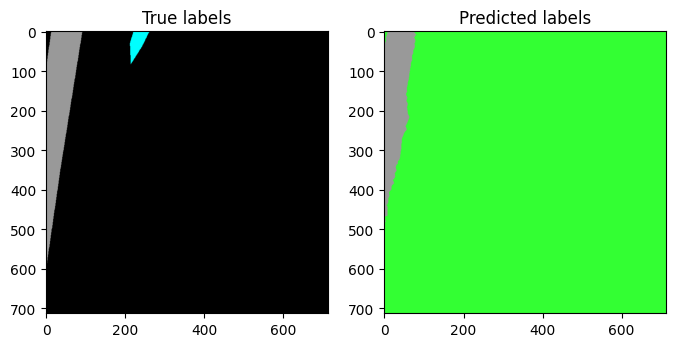

57 data/image/9027.jpg


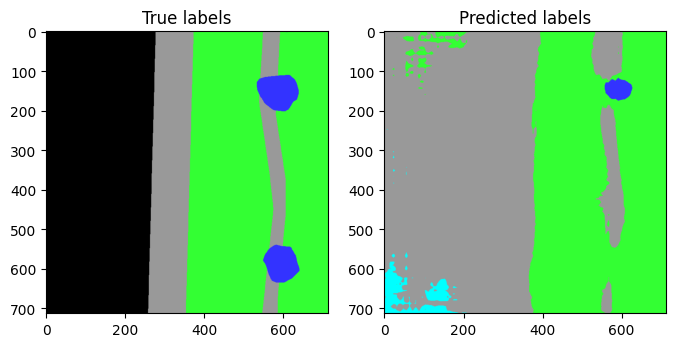

58 data/image/9278.jpg


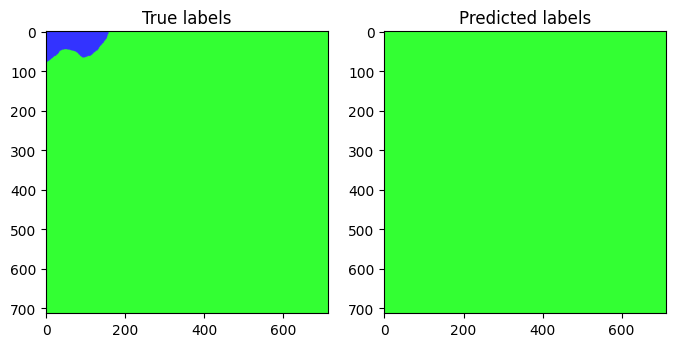

59 data/image/9876.jpg


In [226]:
#display predictions on the test set
nb_images = 8
if all_images : 
    nb_images = 60
for i in range(nb_images):
    display_all(test_ground_truths, test_predictions, i)
    print(i, test_dataset.data[i][0])